In [29]:
import pandas as pd
import pypsa
import urllib3
import plotly.graph_objects as go
import calendar
urllib3.disable_warnings()

In [30]:
# Load Technology data
# year = 2025
# url = f"https://raw.githubusercontent.com/PyPSA/technology-data/master/outputs/costs_{year}.csv"
# costs = pd.read_csv(url, index_col=[0, 1])
costs = pd.read_csv('data/costs_2025.csv', sep=',', index_col=[0,1])

costs.loc[costs.unit.str.contains("/kW"), "value"] *= 1e3
costs.unit = costs.unit.str.replace("/kW", "/MW")

defaults = {
    "FOM": 0,
    "VOM": 0,
    "efficiency": 1,
    "fuel": 0,
    "investment": 0,
    "lifetime": 25,
    "CO2 intensity": 0,
    "discount rate": 0.07,
}
costs = costs.value.unstack().fillna(defaults)

costs.at["OCGT", "fuel"] = costs.at["gas", "fuel"]
costs.at["OCGT", "CO2 intensity"] = costs.at["gas", "CO2 intensity"]

costs["marginal_cost"] = costs["VOM"] + costs["fuel"] / costs["efficiency"]


In [31]:
def annuity(n,r):
    """ Calculate the annuity factor for an asset with lifetime n years and
    discount rate  r """

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


In [32]:
annuity = costs.apply(lambda x: annuity(x["lifetime"], x["discount rate"]), axis=1)
costs["capital_cost"] = (annuity + costs["FOM"] / 100) * costs["investment"]

In [33]:
print("Capital cost for onshore wind:", costs.at["onwind", "capital_cost"])
print("Capital cost for solar:", costs.at["solar", "capital_cost"])
print("Capital cost for OCGT:", costs.at["OCGT", "capital_cost"])
print("Capital cost for coal:", costs.at["coal", "capital_cost"])
print("Capital cost for offshore wind:", costs.at["offwind", "capital_cost"])
print("Capital cost for oil:", costs.at["oil", "capital_cost"])
print("Capital cost for biomass:", costs.at["biomass", "capital_cost"])

Capital cost for onshore wind: 107441.45702058321
Capital cost for solar: 63114.92398493304
Capital cost for OCGT: 48739.697512920015
Capital cost for coal: 337208.02744802914
Capital cost for offshore wind: 184567.39355010682
Capital cost for oil: 40272.798145584995
Capital cost for biomass: 294201.05117025424


In [34]:

print("MC gas", costs.at["gas", "marginal_cost"])
print("MC OCGT", costs.at["OCGT", "marginal_cost"])
print("MC coal", costs.at["coal", "marginal_cost"])
print("MC biomass", costs.at["biomass", "marginal_cost"])
print("MC oil", costs.at["oil", "marginal_cost"])

MC gas 24.568
MC OCGT 65.42372839506173
MC coal 30.098840449438203
MC biomass 15.828205128205129
MC oil 157.52387142857143


In [35]:
network = pypsa.Network()

In [36]:
def optimizer(year, co2_limit=None):
    
    if co2_limit is not None:
        network.add("GlobalConstraint",
                    "co2_limit",
                    type="primary_energy",
                    carrier_attribute="co2_emissions",
                    sense="<=",
                    constant=co2_limit,
                    overwrite=True)
    hours_in_year = pd.date_range(f'{year}-01-01 00:00Z',
                                f'{year}-12-31 23:00Z',
                                freq='h')

    network.set_snapshots(hours_in_year.values)

    network.add("Bus",
                "electricity bus", overwrite=True)

    # load electricity demand data
    df_elec = pd.read_csv('data/electricity_demand.csv', sep=';', index_col=0) # in MWh
    df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime
    country='IRL'
    print(df_elec[country].head())

    # add load to the bus
    network.add("Load",
        "load",
        bus="electricity bus",
        p_set=df_elec[country].values,
        overwrite=True)
    

    # add the different carriers, only gas emits CO2
    network.add("Carrier", "gas", co2_emissions= costs.at["gas", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "onshorewind", overwrite=True)
    network.add("Carrier", "solar", overwrite=True)
    network.add("Carrier", "coal", co2_emissions = costs.at["coal", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "biomass", co2_emissions = costs.at["biomass", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "oil", co2_emissions = costs.at["oil", "CO2 intensity"], overwrite=True) # in t_CO2/MWh_th
    network.add("Carrier", "offshorewind", overwrite=True)

    # add onshore wind generator
    df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
    CF_wind = df_onshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "onshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="onshorewind",
                p_nom_max=4810-25.2, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
                capital_cost =costs.at["onwind", "capital_cost"] , # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_wind.values,
                overwrite=True)

    # add solar PV generator
    df_solar = pd.read_csv('data/pv_optimal.csv', sep=';', index_col=0)
    df_solar.index = pd.to_datetime(df_solar.index)
    CF_solar = df_solar[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "solar",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="solar",
                p_nom_max = 740, # maximum capacity can be limited due to environmental constraints Based on electricity maps
                capital_cost = costs.at["solar", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_solar.values,
                overwrite=True)

    # add OCGT (Open Cycle Gas Turbine) generator
    network.add("Generator",
                "OCGT",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="gas",
                p_nom_max=4270, #based on electricity maps
                capital_cost = costs.at["OCGT", "capital_cost"], #in €/MW
                marginal_cost = costs.at["OCGT", "marginal_cost"],
                overwrite=True)

    # add Coal generator
    network.add("Generator",
                "Coal",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="coal",
                p_nom_max=920, #based on electricity maps
                capital_cost = costs.at["coal", "capital_cost"], #in €/MW
                marginal_cost = costs.at["coal", "marginal_cost"],
                overwrite=True)

    # add biomass generator
    network.add("Generator",
                "Biomass",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="biomass",
                p_nom_max=70, #based on electricity maps 
                capital_cost = costs.at["biomass", "capital_cost"], #in €/MW
                marginal_cost = costs.at["biomass", "marginal_cost"],
                overwrite=True)

    # add oil generator
    network.add("Generator",
                "Oil",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="oil",
                p_nom_max=830, #based on electricity maps
                capital_cost = costs.at["oil", "capital_cost"], #in €/MW
                marginal_cost = costs.at["oil", "marginal_cost"],
                overwrite=True)

    # add offshore wind generator
    df_offshorewind = pd.read_csv('data/offshore_wind_1979-2017.csv', sep=';', index_col=0)
    df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
    CF_offshorewind = df_offshorewind[country][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    network.add("Generator",
                "offshorewind",
                bus="electricity bus",
                p_nom_extendable=True,
                carrier="offshorewind",
                p_nom_max=25.2, # maximum capacity can be limited due to environmental constraints. #Ireland doesnt have offshore wind today, but are proposing to install 5GW soon
                capital_cost = costs.at["offwind", "capital_cost"], # in €/MW
                marginal_cost = 0,
                p_max_pu = CF_offshorewind.values,
                overwrite=True)
    

    #Optimization
    status = network.optimize(solver_name='gurobi', solver_options={'OutputFlag': 0})


    objective = network.objective
    capacities = network.generators.p_nom_opt #in MW
    loadConsumption = network.loads_t.p
    generation = network.generators_t.p
    snapshots = network.snapshots
    
    
    

    return objective, capacities, loadConsumption, generation, snapshots, status




In [37]:
objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015, None)

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.77it/s]
INFO:linopy.io: Writing time: 1.0s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-866vtsqq.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-866vtsqq.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 131414 rows, 61327 columns, 240914 nonzeros


INFO:gurobipy:obj: 131414 rows, 61327 columns, 240914 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131414 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [12]:
status[1]

'optimal'

In [38]:
def plot_dispatch_winter():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot[:96], y=loadConsumption['load'][:96], mode='lines', name='demand', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['onshorewind'][:96], mode='lines', name='onshore wind', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['solar'][:96], mode='lines', name='solar', line=dict(color='orange')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['OCGT'][:96], mode='lines', name='gas (OCGT)', line=dict(color='brown')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Coal'][:96], mode='lines', name='coal', line=dict(color='grey')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Biomass'][:96], mode='lines', name='biomass', line=dict(color='green')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Oil'][:96], mode='lines', name='oil', line=dict(color='black')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['offshorewind'][:96], mode='lines', name='offshore wind', line=dict(color='purple')))

    fig.update_layout(title='Electricity Dispatch Week 1 2015',
                    xaxis_title='Time',
                    yaxis_title='Power (MW)',
                    legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()

In [39]:
plot_dispatch_winter()

# B)

In [40]:
objective, capacities, loadConsumption, generation, snapshot, staus = optimizer(2015, 2730000)
plot_dispatch_winter()

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 12.18it/s]
INFO:linopy.io: Writing time: 0.95s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-lgmrgept.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-lgmrgept.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [41]:
objectives = {}
capacities_dic = {}
loadConsumptions = {}
generations = {}
snapshots = {}
for Co2_limit in range(2730000, 2900000, 30000):
    objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015, Co2_limit)
    if status[1] == "optimal":
        objectives[Co2_limit] = objective
        capacities_dic[Co2_limit] = capacities
        loadConsumptions[Co2_limit] = loadConsumption
        generations[Co2_limit] = generation
        snapshots[Co2_limit] = snapshot
    

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.48it/s]
INFO:linopy.io: Writing time: 0.97s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-ka3x86_h.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-ka3x86_h.lp


Reading time = 0.33 seconds


INFO:gurobipy:Reading time = 0.33 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.78it/s]
INFO:linopy.io: Writing time: 0.98s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-osit5gcp.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-osit5gcp.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.98it/s]
INFO:linopy.io: Writing time: 0.93s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-gvpr29dj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-gvpr29dj.lp


Reading time = 0.32 seconds


INFO:gurobipy:Reading time = 0.32 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 16.16it/s]
INFO:linopy.io: Writing time: 0.96s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-g0dyjrx8.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-g0dyjrx8.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 13.06it/s]
INFO:linopy.io: Writing time: 0.95s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-eanthomj.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-eanthomj.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 16.30it/s]
INFO:linopy.io: Writing time: 0.91s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-uvr_o2au.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-uvr_o2au.lp


Reading time = 0.26 seconds


INFO:gurobipy:Reading time = 0.26 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [42]:
from plotly.subplots import make_subplots

# Create a 2-row, 3-column subplot layout
fig = make_subplots(rows=2, cols=3, 
                    specs=[[{'type': 'domain'}]*3, [{'type': 'domain'}]*3],
                    subplot_titles=[f"CO2 limit: {limit} tonCO2" for limit in objectives.keys()])

colors = ['blue', 'orange', 'brown', 'grey', 'green', 'black', 'purple']
labels = ['onshore wind', 'solar', 'gas (OCGT)', 'coal', 'biomass', 'oil', 'offshore wind']

# Add a pie chart for each CO2 limit
row, col = 1, 1
for i, co2_limit in enumerate(objectives.keys()):
    gen = generations[co2_limit]
    sizes = [
        gen['onshorewind'].sum(),
        gen['solar'].sum(),
        gen['OCGT'].sum(),
        gen['Coal'].sum(),
        gen['Biomass'].sum(),
        gen['Oil'].sum(),
        gen['offshorewind'].sum()
    ]

    fig.add_trace(go.Pie(labels=labels, values=sizes, marker=dict(colors=colors), name=str(co2_limit)),
                  row=row, col=col)

    # Update row/col
    col += 1
    if col > 3:
        col = 1
        row += 1

fig.update_layout(title_text="Electricity Mix for different CO2 Limits", height=700, width=1000)
fig.show()
#pio.write_image(fig, "electricity_mix_co2_constraint.pdf", format='pdf')

Based on research, the CO2-emissions from electricity production was 7.56mT CO2-eq in 2023. This will now be the limit:


In [ ]:
network.add("GlobalConstraint",
                 "co2_limit",
                 type="primary_energy",
                 carrier_attribute="co2_emissions",
                 sense="<=",
                 constant=7560000,
                 overwrite=True)
objective, capacities, loadConsumption, generation, snapshot, status = optimizer(2015)



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 40.55it/s]
INFO:linopy.io: Writing time: 0.38s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-02-12


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-02-12


Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-cgvzk_4i.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/kq/4zrjw9c97lz3tyvhdfpynqqc0000gn/T/linopy-problem-cgvzk_4i.lp


Reading time = 0.12 seconds


INFO:gurobipy:Reading time = 0.12 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


# C)

In this task we will use a CO2 allowance of 3mT

In [50]:


objectives = {}
capacities_dic = {}
loadConsumptions = {}
generations = {}
snapshots = {}


for year in range(2013, 2017):
    if not calendar.isleap(year):  # only hit non-leap years
        objective, capacities, loadConsumption, generation, snapshot, status = optimizer(year, 2900000)
        if status[1] == "optimal":
            print(f"Year {year} is optimal")
            objectives[year] = objective
            capacities_dic[year] = capacities
            loadConsumptions[year] = loadConsumption
            generations[year] = generation
            snapshots[year] = snapshot



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.84it/s]
INFO:linopy.io: Writing time: 0.92s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-jq4jfmck.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-jq4jfmck.lp


Reading time = 0.27 seconds


INFO:gurobipy:Reading time = 0.27 seconds


obj: 131415 rows, 61327 columns, 267206 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267206 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.75e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2013 is optimal
utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.90it/s]
INFO:linopy.io: Writing time: 0.91s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-e5w79_g6.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-e5w79_g6.lp


Reading time = 0.33 seconds


INFO:gurobipy:Reading time = 0.33 seconds


obj: 131415 rows, 61327 columns, 267211 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267211 nonzeros
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 14.23it/s]
INFO:linopy.io: Writing time: 0.96s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-49p66j8w.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-49p66j8w.lp


Reading time = 0.36 seconds


INFO:gurobipy:Reading time = 0.36 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


Year 2015 is optimal


## Objective with optimal CO2 limit for 2015

In [51]:
objective_optimalCO2, capacities, loadConsumption, generation, snapshot, status = optimizer("2015", 2800000)


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 2/2 [00:00<00:00, 15.91it/s]
INFO:linopy.io: Writing time: 0.94s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-02zu2t69.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-02zu2t69.lp


Reading time = 0.27 seconds


INFO:gurobipy:Reading time = 0.27 seconds


obj: 131415 rows, 61327 columns, 267194 nonzeros


INFO:gurobipy:obj: 131415 rows, 61327 columns, 267194 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 61327 primals, 131415 duals
Objective: 1.70e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper were not assigned to the network.


In [52]:
#make a 100% stacket area chart of the capacities for all years
def plot_capacities(years):
    fig = go.Figure()

    for generator in ['onshorewind', 'solar', 'OCGT', 'Coal', 'Biomass', 'Oil', 'offshorewind']:
        fig.add_trace(go.Scatter(x=years, y=[capacities_dic[year][generator] for year in years],
                                 mode='lines+markers',
                                 name=generator))

    fig.update_layout(title='Capacities over the years',
                      xaxis_title='Year',
                      yaxis_title='Capacity (MW)',
                      legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
available_years = [year for year in range(2013, 2017) 
                   if year in capacities_dic and not calendar.isleap(year)]

plot_capacities(available_years)

In [54]:
#make a 100% stacket area chart of the generation for all years
def plot_generation(years):
    fig = go.Figure()

    for generator in ['onshorewind', 'solar', 'OCGT', 'Coal', 'Biomass', 'Oil', 'offshorewind']:
        fig.add_trace(go.Scatter(x=years, y=[sum(generations[year][generator]) for year in years],
                                 mode='lines+markers',
                                 name=generator))

    fig.update_layout(title='Generation over the years',
                      xaxis_title='Year',
                      yaxis_title='Capacity (MW)',
                      legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
available_years = [year for year in range(2013, 2017) 
                   if year in capacities_dic and not calendar.isleap(year)]

plot_capacities(available_years)

# D)

In [ ]:
#values for pumped hydro
#costs.loc["Pumped-Storage-Hydro-store", :].T

In [55]:
print(costs.at["Pumped-Storage-Hydro-store", "capital_cost"])
print(costs.at["coal", "capital_cost"])
print(costs.at["offwind", "capital_cost"])
print(costs.at["OCGT", "capital_cost"])
print(costs.at["onwind", "capital_cost"])
print(costs.at["solar", "capital_cost"])
print(costs.at["oil", "capital_cost"])

4310.759736764704
337208.02744802914
184567.39355010682
48739.697512920015
107441.45702058321
63114.92398493304
40272.798145584995


In [56]:
#Create a new carrier
network.add("Carrier",
              "Hydro")

#Create a new bus
network.add("Bus",
          "Hydro Bus",
          carrier = "Hydro")

#Connect the Pumped Hydr Storage (PHS) to the Hydro Bus
network.add("Store",
          "PHS",
          bus = "Hydro Bus",
          e_nom_extendable = True,
          e_cyclic = True,
          e_nom_max = 240, #in MWh
          capital_cost = costs.at["Pumped-Storage-Hydro-store", "capital_cost"], 
          overwrite=True
)

#Add the link "Hydro pump" that transport energy from the electricity bus (bus0) to the Hydro bus (bus1)
#with 80% efficiency
network.add("Link",
          "Hydro pump",
          bus0 = "electricity bus",
          bus1 = "Hydro Bus",
          p_nom_extendable = True,
          efficiency = 0.85,
          capital_cost = 0, 
            overwrite=True
          )

#Add the link "Hydro turbine" that transports energy from the Hydro bus (bus0) to the electricity bus (bus1)
#with 58% efficiency
network.add("Link",
          "Hydro turbine",
          bus0 = "Hydro Bus",
          bus1 = "electricity bus",
          p_nom_extendable = True,
          efficiency = 0.9,
          capital_cost = 0,
            overwrite=True
        
          )



Index(['Hydro turbine'], dtype='object')

utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 30.90it/s]
INFO:linopy.io: Writing time: 1.66s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-xlj0c8x1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-xlj0c8x1.lp


Reading time = 0.40 seconds


INFO:gurobipy:Reading time = 0.40 seconds


obj: 201499 rows, 96370 columns, 416118 nonzeros


INFO:gurobipy:obj: 201499 rows, 96370 columns, 416118 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 201499 duals
Objective: 1.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.
/Users/Noa/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

/Users/Noa/Library/Python/3.12/lib/python/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.

/Users/Noa/Library/Python/3.12/lib/python/site-packa

<Axes: xlabel='snapshot', ylabel='Hydro storage'>

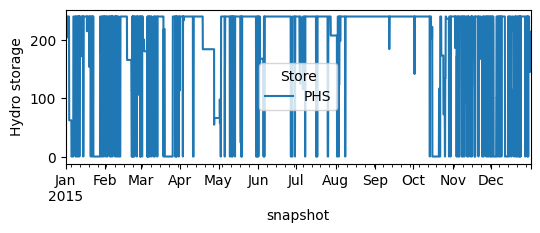

In [57]:

objective_hydro, capacities, loadConsumption, generation, snapshot, status = optimizer("2015", 2800000)
network.stores_t.e.plot(figsize=(6, 2), ylabel="Hydro storage")



In [58]:
print("objective_optimalCO2: ", objective_optimalCO2)
print("objective_hydro: ", objective_hydro)

print("Savings using a pumped hydro storage: ", objective_optimalCO2 - objective_hydro)


objective_optimalCO2:  1698562436.721885
objective_hydro:  1689215862.486819
Savings using a pumped hydro storage:  9346574.235065937


In [59]:
# Re-run the optimizer to ensure 'Hydro Bus' is included in the network
objective_hydro, capacities, loadConsumption, generation, snapshot, status = optimizer(2015, 2800000)



utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 32.85it/s]
INFO:linopy.io: Writing time: 1.63s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-6g44ef_1.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-6g44ef_1.lp


Reading time = 0.46 seconds


INFO:gurobipy:Reading time = 0.46 seconds


obj: 201499 rows, 96370 columns, 416118 nonzeros


INFO:gurobipy:obj: 201499 rows, 96370 columns, 416118 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 96370 primals, 201499 duals
Objective: 1.69e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


In [60]:
#print the marginal price from electricity bus
print(network.buses_t.marginal_price['electricity bus'])
#plot the marginal price from electricity bus

def plot_marginal_price():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot, y=network.buses_t.marginal_price['electricity bus'],
                             mode='lines', name='marginal price', line=dict(color='black')))

    fig.update_layout(title='Marginal Price',
                      xaxis_title='Time',
                      yaxis_title='Price (€/MWh)',
                      legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_marginal_price()

snapshot
2015-01-01 00:00:00    70.807194
2015-01-01 01:00:00    70.807194
2015-01-01 02:00:00    70.807194
2015-01-01 03:00:00     0.000000
2015-01-01 04:00:00     0.000000
                         ...    
2015-12-31 19:00:00    70.807194
2015-12-31 20:00:00    70.807194
2015-12-31 21:00:00    70.807194
2015-12-31 22:00:00    70.807194
2015-12-31 23:00:00    70.807194
Name: electricity bus, Length: 8760, dtype: float64


In [61]:

# make a df with the difference between hours
network.stores_t.e['PHS'].diff()

storage_generation = network.stores_t.e['PHS'].diff().apply(lambda x: x if x > 0 else 0)
storage_load = network.stores_t.e['PHS'].diff().apply(lambda x: x if x < 0 else 0)

storage_load = storage_load * -1

# print(network.stores_t.e['PHS'])
# print(network.stores_t.e['PHS'].diff().head)
# print(storage_generation.head(10))
# print(storage_load.head(10))


In [62]:
def plot_dispatch_winter_including_hydro():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot[:96], y=loadConsumption['load'][:96], mode='lines', name='demand', line=dict(color='black', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['onshorewind'][:96], mode='lines', name='onshore wind', line=dict(color='blue', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['solar'][:96], mode='lines', name='solar', line=dict(color='orange', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['OCGT'][:96], mode='lines', name='gas (OCGT)', line=dict(color='brown', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Coal'][:96], mode='lines', name='coal', line=dict(color='grey', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Biomass'][:96], mode='lines', name='biomass', line=dict(color='green', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['Oil'][:96], mode='lines', name='oil', line=dict(color='black', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot[:96], y=generation['offshorewind'][:96], mode='lines', name='offshore wind', line=dict(color='purple', shape='hv')))
    # add storage_load
    fig.add_trace(go.Scatter(x=snapshot[:96], y=storage_load[:96], mode='lines', name='storage load', line=dict(color='red', shape='hv')))
    # add storage_generation
    fig.add_trace(go.Scatter(x=snapshot[:96], y=storage_generation[:96], mode='lines', name='storage generation', line=dict(color='green', shape='hv')))
    fig.update_layout(title='Electricity Dispatch Week 1 2015',
                    xaxis_title='Time',
                    yaxis_title='Power (MW)',
                    legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_dispatch_winter_including_hydro()

## **Make sure that load and generation fits with the patterns**

# E)

In [63]:
print(network.global_constraints.constant) # CO2 limit (constant in the constraint)
print("Price pr. ton CO2 increase in the system\n", network.global_constraints.mu) # CO2 price (Lagrance multiplier in the constraint)

GlobalConstraint
co2_limit    2800000.0
Name: constant, dtype: float64
Price pr. ton CO2 increase in the system
 GlobalConstraint
co2_limit   -27.189218
Name: mu, dtype: float64


**Search for information on CO2 taxes**

# F)

### Adding Britain though link:

In [64]:
df_onshorewind = pd.read_csv('data/onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
CF_wind_FRA = df_onshorewind['FRA'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
CF_wind_GBR = df_onshorewind['GBR'][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]

In [65]:


#Add the link "Hydro pump" that transport energy from the electricity bus (bus0) to the Hydro bus (bus1)
#with 80% efficiency

cable_length_Ireland_Britain = 160 # in km based on the actial green link cable
p_nom_cable_britain = 500
p_nom_onshore_britain = 32800

network.add("Bus",
                "electricity bus Britain",
                carrier="electricity",
                overwrite=True)


network.add("Generator",
            "onshorewind Britain",
            bus="electricity bus Britain",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=p_nom_onshore_britain*0.01, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
            #capital_cost = costs.at["onwind", "capital_cost"], # in €/MW  # exclude capital cost because it is not part of the system
            marginal_cost = 0,
            p_max_pu = CF_wind_GBR.values,
            overwrite=True)


network.add("Link",
             'Ireland - Britain',
             bus0="electricity bus",
             bus1="electricity bus Britain",
             p_nom_extendable=True, # capacity is optimised
             p_nom_max=p_nom_cable_britain, # maximum capacity can be limited due to environmental constraints. Based on electricity maps - minus the off shore wind capacity
             p_min_pu=-1,
             length=cable_length_Ireland_Britain, # length (in km) between country a and country b
             capital_cost=400*cable_length_Ireland_Britain, 
             overwrite=True) # capital cost * length



objective_with_britain, capacities, loadConsumption, generation, snapshot, status = optimizer("2015", 2800000)





utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus Britain', 'electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump', 'Ireland - Britain'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 29.54it/s]
INFO:linopy.io: Writing time: 1.73s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-hvqoggx7.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-hvqoggx7.lp


Reading time = 0.47 seconds


INFO:gurobipy:Reading time = 0.47 seconds


obj: 245303 rows, 113892 columns, 503722 nonzeros


INFO:gurobipy:obj: 245303 rows, 113892 columns, 503722 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 113892 primals, 245303 duals
Objective: 1.66e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


### Adding France though link:

In [67]:
cable_length_Ireland_France = 575 # in km based on the actial link Celtic interconnector
p_nom_cable_france = 700
p_nom_onshore_france = 61800

network.add("Bus",
                "electricity bus France",
                carrier="electricity",
                overwrite=True)


network.add("Generator",
            "onshorewind France",
            bus="electricity bus France",
            p_nom_extendable=True,
            carrier="onshorewind",
            p_nom_max=p_nom_onshore_france*0.01,
            #capital_cost = costs.at["onwind", "capital_cost"], # in €/MW # exclude capital cost because it is not part of the system
            marginal_cost = 0,
            p_max_pu = CF_wind_FRA.values,
            overwrite=True)


network.add("Link",
             'Ireland - France',
             bus0="electricity bus",
             bus1="electricity bus France",    
             p_nom_extendable=True, # capacity is optimised
             p_nom_max = p_nom_cable_france,
             p_min_pu=-1,
             length=cable_length_Ireland_France, # length (in km) between country a and country b
             capital_cost=400*cable_length_Ireland_France, 
             overwrite = True) # capital cost * length
objective_with_britain_and_france, capacities, loadConsumption, generation, snapshot, status = optimizer("2015", 2800000)




utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus Britain', 'electricity bus France', 'electricity bus'], dtype='object', name='Bus')
Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 21.14it/s]
INFO:linopy.io: Writing time: 2.12s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-5wxhk5a4.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-5wxhk5a4.lp


Reading time = 0.61 seconds


INFO:gurobipy:Reading time = 0.61 seconds


obj: 289107 rows, 131414 columns, 591326 nonzeros


INFO:gurobipy:obj: 289107 rows, 131414 columns, 591326 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 131414 primals, 289107 duals
Objective: 1.63e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


In [68]:
print("Objective value before adding links: ", objective_hydro)
print("Objective value after adding Britain: ", objective_with_britain)
print("Objective value after adding France: ", objective_with_britain_and_france)

Objective value before adding links:  1689215862.486819
Objective value after adding Britain:  1658309342.3457153
Objective value after adding France:  1634824037.3793502


In [69]:
#print the links
print("Link between Ireland and Britain: ", network.links_t.p0['Ireland - Britain'])
print("Link between Ireland and France: ", network.links_t.p0['Ireland - France'])
network.links_t.p0


Link between Ireland and Britain:  snapshot
2015-01-01 00:00:00   -153.504
2015-01-01 01:00:00   -153.504
2015-01-01 02:00:00   -153.504
2015-01-01 03:00:00   -153.504
2015-01-01 04:00:00      0.000
                        ...   
2015-12-31 19:00:00   -153.504
2015-12-31 20:00:00   -139.728
2015-12-31 21:00:00   -110.208
2015-12-31 22:00:00    -92.496
2015-12-31 23:00:00    -83.968
Name: Ireland - Britain, Length: 8760, dtype: float64
Link between Ireland and France:  snapshot
2015-01-01 00:00:00    -71.070
2015-01-01 01:00:00    -74.778
2015-01-01 02:00:00      0.000
2015-01-01 03:00:00      0.000
2015-01-01 04:00:00      0.000
                        ...   
2015-12-31 19:00:00   -122.982
2015-12-31 20:00:00   -122.982
2015-12-31 21:00:00   -122.982
2015-12-31 22:00:00   -113.712
2015-12-31 23:00:00    -93.318
Name: Ireland - France, Length: 8760, dtype: float64


Link                  Hydro pump  Hydro turbine  Ireland - Britain  \
snapshot                                                             
2015-01-01 00:00:00     0.000000     108.889333           -153.504   
2015-01-01 01:00:00     0.000000       0.000000           -153.504   
2015-01-01 02:00:00   195.230638     165.946043           -153.504   
2015-01-01 03:00:00  1169.102979     753.737532           -153.504   
2015-01-01 04:00:00     0.000000       0.000000              0.000   
...                          ...            ...                ...   
2015-12-31 19:00:00     0.000000       0.000000           -153.504   
2015-12-31 20:00:00     0.000000       0.000000           -139.728   
2015-12-31 21:00:00     0.000000       0.000000           -110.208   
2015-12-31 22:00:00     0.000000       0.000000            -92.496   
2015-12-31 23:00:00     0.000000     131.110667            -83.968   

Link                 Ireland - France  
snapshot                               
2015-01-01 00:00:00           -71.070  
2015-01-01 01:00:00           -74.778  
2015-01-01 02:00:00             0.000  
2015-01-01 03:00:00             0.000  
2015-01-01 04:00:00             0.000  
...                               ...  
2015-12-31 19:00:00          -122.982  
2015-12-31 20:00:00          -122.982  
2015-12-31 21:00:00          -122.982  
2015-12-31 22:00:00          -113.712  
2015-12-31 23:00:00           -93.318  

[8760 rows x 4 columns]

### **Vi er gået med fixed capacity hvilket er en ret simpel løsning. Derfor kunne man overveje om vi skulle tilføje hele systemet i frankrig og britain. Desuden ses det at objektværdien ikke ændrer sig når frankrig også sættes på hvilket vi ikke helt kan få til at give mening**

In [70]:
def plot_dispatch_winter_with_Links():
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=snapshot, y=loadConsumption['load'], mode='lines', name='demand', line=dict(color='black', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['onshorewind'], mode='lines', name='onshore wind', line=dict(color='blue', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['solar'], mode='lines', name='solar', line=dict(color='orange', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['OCGT'], mode='lines', name='gas (OCGT)', line=dict(color='brown', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['Coal'], mode='lines', name='coal', line=dict(color='grey', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['Biomass'], mode='lines', name='biomass', line=dict(color='green', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['Oil'], mode='lines', name='oil', line=dict(color='black', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['offshorewind'], mode='lines', name='offshore wind', line=dict(color='purple', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['onshorewind Britain'], mode='lines', name='onshore wind Britain', line=dict(color='blue', shape='hv')))
    fig.add_trace(go.Scatter(x=snapshot, y=generation['onshorewind France'], mode='lines', name='onshore wind France', line=dict(color='brown', shape='hv')))
    #add
    # add storage_load
    fig.add_trace(go.Scatter(x=snapshot, y=storage_load, mode='lines', name='storage load', line=dict(color='red', shape='hv')))
    # add storage_generation
    fig.add_trace(go.Scatter(x=snapshot, y=storage_generation, mode='lines', name='storage generation', line=dict(color='green', shape='hv')))
    fig.update_layout(title='Electricity Dispatch Week 1 2015',
                    xaxis_title='Time',
                    yaxis_title='Power (MW)',
                    legend=dict(x=0, y=1, traceorder='normal'))

    fig.show()
plot_dispatch_winter_with_Links()



# G)

utc_time
2015-01-01 00:00:00+00:00    4375.713949
2015-01-01 01:00:00+00:00    4245.265903
2015-01-01 02:00:00+00:00    4252.621996
2015-01-01 03:00:00+00:00    4208.089044
2015-01-01 04:00:00+00:00    4089.857785
Name: IRL, dtype: float64
utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['electricity bus Britain', 'electricity bus France', 'heat bus',
       'electricity bus'],
      dtype='object', name='Bus')
Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France', 'heat pump'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 23.75it/s]
INFO:linopy.io: Writing time: 2.19s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-23ajl5hy.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-23ajl5hy.lp


Reading time = 0.67 seconds


INFO:gurobipy:Reading time = 0.67 seconds


obj: 315388 rows, 140175 columns, 635127 nonzeros


INFO:gurobipy:obj: 315388 rows, 140175 columns, 635127 nonzeros
INFO:linopy.solvers:Unable to save solution file. Raised error: Unable to retrieve attribute 'X'
Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



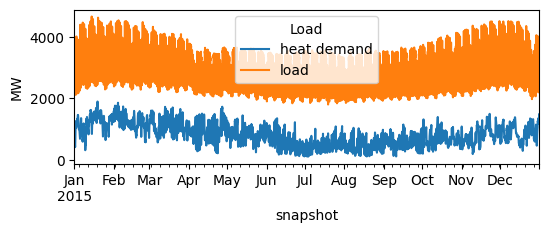

In [74]:
# load electricity demand data
df_heat = pd.read_csv('data/heat_demand.csv', sep=';', index_col=0) # in MWh
df_heat.index = pd.to_datetime(df_heat.index) #change index to datatime
country='IRL'
print(df_heat[country].head())


network.add("Bus",
    "heat bus",
    carrier="heat",
    overwrite=True)

# add load to the bus
network.add("Load",
    "heat demand",
    bus="heat bus",
    p_set=df_heat[country].values*0.2,
    overwrite=True)
network.loads_t.p_set.plot(figsize=(6, 2), ylabel="MW")

network.add("Link", 
    "heat pump",
    carrier="heat pump",
    bus0="electricity bus",
    bus1="heat bus",
    p_nom_extendable=True,
    capital_cost=costs.at["central air-sourced heat pump", "capital_cost"]*0.1,  # €/MWe/a
    efficiency = 3, #change with COP values
    overwrite=True)



objective_with_heatpump, capacities, loadConsumption, generation, snapshot, status = optimizer("2015")




In [75]:
network.links_t.p0['heat pump']

KeyError: 'heat pump'

In [76]:
network.add("Bus", "gas bus")

# We add a gas store with energy capacity and an initial filling level much higher than the required gas consumption, 
# this way gas supply is unlimited
network.add("Store", "gas storage", e_initial=1e6, e_nom=1e6, bus="gas bus") 

network.add(
    "Link",
    "CHP",
    bus0="gas bus",
    bus1="electricity bus",
    bus2="heat bus",
    p_nom=1000,
    marginal_cost=80, #gas price maybe
    efficiency=0.4,
    efficiency2=0.4,
    capital_cost=costs.at["decentral CHP", "capital_cost"],  # €/MWe/a

)

Index(['CHP'], dtype='object')

In [77]:
objective_with_heatpump_and_CHP, capacities, loadConsumption, generation, snapshot, status = optimizer("2015")


utc_time
2015-01-01 00:00:00+00:00    2651.0
2015-01-01 01:00:00+00:00    2412.0
2015-01-01 02:00:00+00:00    2256.0
2015-01-01 03:00:00+00:00    2170.0
2015-01-01 04:00:00+00:00    2136.0
Name: IRL, dtype: float64


Index(['gas storage'], dtype='object', name='Store')
Index(['electricity bus Britain', 'electricity bus France', 'heat bus',
       'gas bus', 'electricity bus'],
      dtype='object', name='Bus')
Index(['Hydro pump', 'Ireland - Britain', 'Ireland - France', 'heat pump',
       'CHP'],
      dtype='object', name='Link')
INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.model:Solver options:
 - OutputFlag: 0
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 17.07it/s]
INFO:linopy.io: Writing time: 2.63s


Set parameter Username


INFO:gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2026-03-26


INFO:gurobipy:Academic license - for non-commercial use only - expires 2026-03-26


Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-j_6sxhe9.lp


INFO:gurobipy:Read LP format model from file /private/var/folders/bw/f3ltfwx96zxgwnbblkhmxqvw0000gp/T/linopy-problem-j_6sxhe9.lp


Reading time = 0.70 seconds


INFO:gurobipy:Reading time = 0.70 seconds


obj: 367948 rows, 166455 columns, 731486 nonzeros


INFO:gurobipy:obj: 367948 rows, 166455 columns, 731486 nonzeros
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 166455 primals, 367948 duals
Objective: 1.81e+09
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Link-ext-p-lower, Link-ext-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-ext-e-lower, Store-ext-e-upper, Store-energy_balance were not assigned to the network.


* Missing the COP for heat pump
* Missing extension to the country links maybe
* How do we know if the CHP is producing heat or electricity
* What should the marginal price of CHP be?
* Check at capital cost for CHP er korrekt (på nette evt.)

In [ ]:
pd.concat([-network.links_t.p1['CHP'], network.generators_t.p], axis=1).sum().plot.pie(figsize=(6, 2), title='Electricity')


In [ ]:
pd.concat([-network.links_t.p2['CHP'],-network.links_t.p1['heat pump']], axis=1).sum().plot.pie(figsize=(6, 2), title='Heat')
